In [ ]:
##########################################################
# ---- Read HH data and take averages based on day and night times ----
##########################################################

# 01_vpd_daytime.R
# This script reads half-hourly data, extracts daytime average vapour pressure deficit (VPD_F_DAY),
# and writes the result to a CSV file.

# ---- Package Installation and Loading ----
# Ensure required packages are installed and loaded
required_packages <- c("dplyr", "lubridate")
installed_packages <- rownames(installed.packages())
for (pkg in required_packages) {
    if (!pkg %in% installed_packages) {
        install.packages(pkg, dependencies = TRUE)
    }
    library(pkg, character.only = TRUE)
}

# ---- Data Reading ----
# Read the half-hourly measurement file (CSV)
data <- read.csv("../data/FLX_CH-Oe2_FLUXNET2015_FULLSET_2004-2023_1-3/FLX_CH-Oe2_FLUXNET2015_FULLSET_HH_2004-2023_1-3.csv")
head(data)      # Preview the first few rows
colnames(data)  # Display column names

# ---- Timestamp Conversion ----
# Convert TIMESTAMP_START and TIMESTAMP_END to character format (prevents scientific notation issues)
data$TIMESTAMP_START <- as.character(data$TIMESTAMP_START)
data$TIMESTAMP_END <- as.character(data$TIMESTAMP_END)

# Extract date from TIMESTAMP_START (first 8 characters: YYYYMMDD format)
data$date <- as.Date(substr(data$TIMESTAMP_START, 1, 8), format = "%Y%m%d")

# Extract hour from TIMESTAMP_START (characters 9-10: HH format)
data$hour <- as.numeric(substr(data$TIMESTAMP_START, 9, 10))

# ---- Filter for Daytime Hours ----
# Define daytime as 6 AM to 6 PM (06:00 to 17:59)
daytime_data <- data %>%
    filter(hour >= 6 & hour < 18)

# ---- Data Aggregation ----
# Calculate daytime average VPD by date
data_daily <- daytime_data %>%
    group_by(date) %>%
    summarise(
        vpd_day = mean(VPD_F * 1.0e2, na.rm = TRUE)  # Daytime average vapour pressure deficit
    ) %>%
    ungroup()

# Calculate nighttime average VPD (18:00 to 05:59)
nighttime_data <- data %>%
    filter(hour < 6 | hour >= 18)

nighttime_daily <- nighttime_data %>%
    group_by(date) %>%
    summarise(
        vpd_night = mean(VPD_F * 1.0e2, na.rm = TRUE)  # Nighttime average vapour pressure deficit
    ) %>%
    ungroup()

# Calculate 24-hour average VPD (all hours)
daily_24h <- data %>%
    group_by(date) %>%
    summarise(
        vpd_24h = mean(VPD_F * 1.0e2, na.rm = TRUE)  # 24-hour average vapour pressure deficit
    ) %>%
    ungroup()

# Merge all VPD calculations into one comprehensive dataframe
data_daily <- data_daily %>%
    left_join(nighttime_daily, by = "date") %>%
    left_join(daily_24h, by = "date")

# ---- Output ----
# Write the daily VPD data to a CSV file
write.csv(data_daily, "../data/01_data_prep/02_vpd.csv", row.names = FALSE)

# ---- Quick Checks ----
head(data_daily)    # Preview the first few rows of daily aggregated data
nrow(data_daily)    # Display total number of days in the dataset

##########################################################
# ---- Read Daily Data ----
##########################################################
# Read the daily measurement file (CSV) for comparison/validation
daily_flux_data <- read.csv("../data/FLX_CH-Oe2_FLUXNET2015_FULLSET_2004-2023_1-3/FLX_CH-Oe2_FLUXNET2015_FULLSET_DD_2004-2023_1-3.csv")

# Convert TIMESTAMP to date format for merging
daily_flux_data$TIMESTAMP <- as.character(daily_flux_data$TIMESTAMP)
daily_flux_data$date <- as.Date(daily_flux_data$TIMESTAMP, format = "%Y%m%d")

# Extract VPD_F from daily flux data for comparison with calculated values
daily_vpd_from_dd <- daily_flux_data %>%
    select(date, VPD_F) %>%
    rename(vpd_daily_flux = VPD_F )  # Rename to distinguish from calculated values
# Convert VPD_F to hectopascals (hPa) if necessary
daily_vpd_from_dd$vpd_daily_flux <- daily_vpd_from_dd$vpd_daily_flux * 1.0e2  # Convert to hPa if needed

# Merge daily flux VPD with existing calculated VPD data
data_daily <- data_daily %>%
    left_join(daily_vpd_from_dd, by = "date")

# Update the CSV file with the new comparison column
write.csv(data_daily, "../data/01_data_prep/02_vpd.csv", row.names = FALSE)

# Preview the final dataset with all VPD variables
head(data_daily)

,TIMESTAMP_START,TIMESTAMP_END,TA_F_MDS,TA_F_MDS_QC,TA_ERA,TA_F,TA_F_QC,SW_IN_POT,SW_IN_F_MDS,SW_IN_F_MDS_QC,...,GPP_DT_CUT_SE,GPP_DT_CUT_05,GPP_DT_CUT_16,GPP_DT_CUT_25,GPP_DT_CUT_50,GPP_DT_CUT_75,GPP_DT_CUT_84,GPP_DT_CUT_95,RECO_SR,RECO_SR_N
,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
1,2.00401e+11,2.00401e+11,-1.186,2,-0.111,-0.111,2,0,0,3,...,0,0,0,0,0,0,0,0,-9999,-9999
2,2.00401e+11,2.00401e+11,-1.186,2,-0.111,-0.111,2,0,0,3,...,0,0,0,0,0,0,0,0,-9999,-9999
3,2.00401e+11,2.00401e+11,-1.244,2,-0.111,-0.111,2,0,0,3,...,0,0,0,0,0,0,0,0,-9999,-9999
4,2.00401e+11,2.00401e+11,-1.290,2,-0.241,-0.241,2,0,0,3,...,0,0,0,0,0,0,0,0,-9999,-9999
5,2.00401e+11,2.00401e+11,-1.328,2,-0.371,-0.371,2,0,0,3,...,0,0,0,0,0,0,0,0,-9999,-9999
6,2.00401e+11,2.00401e+11,-1.304,2,-0.286,-0.286,2,0,0,3,...,0,0,0,0,0,0,0,0,-9999,-9999


[1] "TIMESTAMP_START"                "TIMESTAMP_END"                 
  [3] "TA_F_MDS"                       "TA_F_MDS_QC"                   
  [5] "TA_ERA"                         "TA_F"                          
  [7] "TA_F_QC"                        "SW_IN_POT"                     
  [9] "SW_IN_F_MDS"                    "SW_IN_F_MDS_QC"                
 [11] "SW_IN_ERA"                      "SW_IN_F"                       
 [13] "SW_IN_F_QC"                     "LW_IN_F_MDS"                   
 [15] "LW_IN_F_MDS_QC"                 "LW_IN_ERA"                     
 [17] "LW_IN_F"                        "LW_IN_F_QC"                    
 [19] "LW_IN_JSB"                      "LW_IN_JSB_QC"                  
 [21] "LW_IN_JSB_ERA"                  "LW_IN_JSB_F"                   
 [23] "LW_IN_JSB_F_QC"                 "VPD_F_MDS"                     
 [25] "VPD_F_MDS_QC"                   "VPD_ERA"                       
 [27] "VPD_F"                          "VPD_F_QC"                      
 [29] "PA"                             "PA_ERA"                        
 [31] "PA_F"                           "PA_F_QC"                       
 [33] "P"                              "P_ERA"                         
 [35] "P_F"                            "P_F_QC"                        
 [37] "WS"                             "WS_ERA"                        
 [39] "WS_F"                           "WS_F_QC"                       
 [41] "WD"                             "USTAR"                         
 [43] "RH"                             "PPFD_IN"                       
 [45] "PPFD_DIF"                       "CO2_F_MDS"                     
 [47] "CO2_F_MDS_QC"                   "TS_F_MDS_1"                    
 [49] "TS_F_MDS_2"                     "TS_F_MDS_3"                    
 [51] "TS_F_MDS_4"                     "TS_F_MDS_5"                    
 [53] "TS_F_MDS_6"                     "TS_F_MDS_7"                    
 [55] "TS_F_MDS_1_QC"                  "TS_F_MDS_2_QC"                 
 [57] "TS_F_MDS_3_QC"                  "TS_F_MDS_4_QC"                 
 [59] "TS_F_MDS_5_QC"                  "TS_F_MDS_6_QC"                 
 [61] "TS_F_MDS_7_QC"                  "SWC_F_MDS_1"                   
 [63] "SWC_F_MDS_2"                    "SWC_F_MDS_3"                   
 [65] "SWC_F_MDS_4"                    "SWC_F_MDS_1_QC"                
 [67] "SWC_F_MDS_2_QC"                 "SWC_F_MDS_3_QC"                
 [69] "SWC_F_MDS_4_QC"                 "G_F_MDS"                       
 [71] "G_F_MDS_QC"                     "LE_F_MDS"                      
 [73] "LE_F_MDS_QC"                    "LE_CORR"                       
 [75] "LE_CORR_25"                     "LE_CORR_75"                    
 [77] "LE_RANDUNC"                     "LE_RANDUNC_METHOD"             
 [79] "LE_RANDUNC_N"                   "LE_CORR_JOINTUNC"              
 [81] "H_F_MDS"                        "H_F_MDS_QC"                    
 [83] "H_CORR"                         "H_CORR_25"                     
 [85] "H_CORR_75"                      "H_RANDUNC"                     
 [87] "H_RANDUNC_METHOD"               "H_RANDUNC_N"                   
 [89] "H_CORR_JOINTUNC"                "EBC_CF_N"                      
 [91] "EBC_CF_METHOD"                  "NIGHT"                         
 [93] "NEE_CUT_REF"                    "NEE_VUT_REF"                   
 [95] "NEE_CUT_REF_QC"                 "NEE_VUT_REF_QC"                
 [97] "NEE_CUT_REF_RANDUNC"            "NEE_VUT_REF_RANDUNC"           
 [99] "NEE_CUT_REF_RANDUNC_METHOD"     "NEE_VUT_REF_RANDUNC_METHOD"    
[101] "NEE_CUT_REF_RANDUNC_N"          "NEE_VUT_REF_RANDUNC_N"         
[103] "NEE_CUT_REF_JOINTUNC"           "NEE_VUT_REF_JOINTUNC"          
[105] "NEE_CUT_USTAR50"                "NEE_VUT_USTAR50"               
[107] "NEE_CUT_USTAR50_QC"             "NEE_VUT_USTAR50_QC"            
[109] "NEE_CUT_USTAR50_RANDUNC"        "NEE_VUT_USTAR50_RANDUNC"       
[111] "NEE_CUT_USTAR50_RANDUNC_METHOD" "NE

date,vpd_day,vpd_night,vpd_24h
<date>,<dbl>,<dbl>,<dbl>
2004-01-01,6.51250,4.004167,5.258333
2004-01-02,0.00000,2.091667,1.045833
2004-01-03,7.08750,14.075000,10.581250
2004-01-04,76.00417,41.058333,58.531250
2004-01-05,23.92917,27.658333,25.793750
2004-01-06,23.83750,5.025000,14.431250


[1] 7305

date,vpd_day,vpd_night,vpd_24h,vpd_daily_flux
<date>,<dbl>,<dbl>,<dbl>,<dbl>
2004-01-01,6.51250,4.004167,5.258333,5.3
2004-01-02,0.00000,2.091667,1.045833,1.0
2004-01-03,7.08750,14.075000,10.581250,10.6
2004-01-04,76.00417,41.058333,58.531250,58.5
2004-01-05,23.92917,27.658333,25.793750,25.8
2004-01-06,23.83750,5.025000,14.431250,14.4


Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."


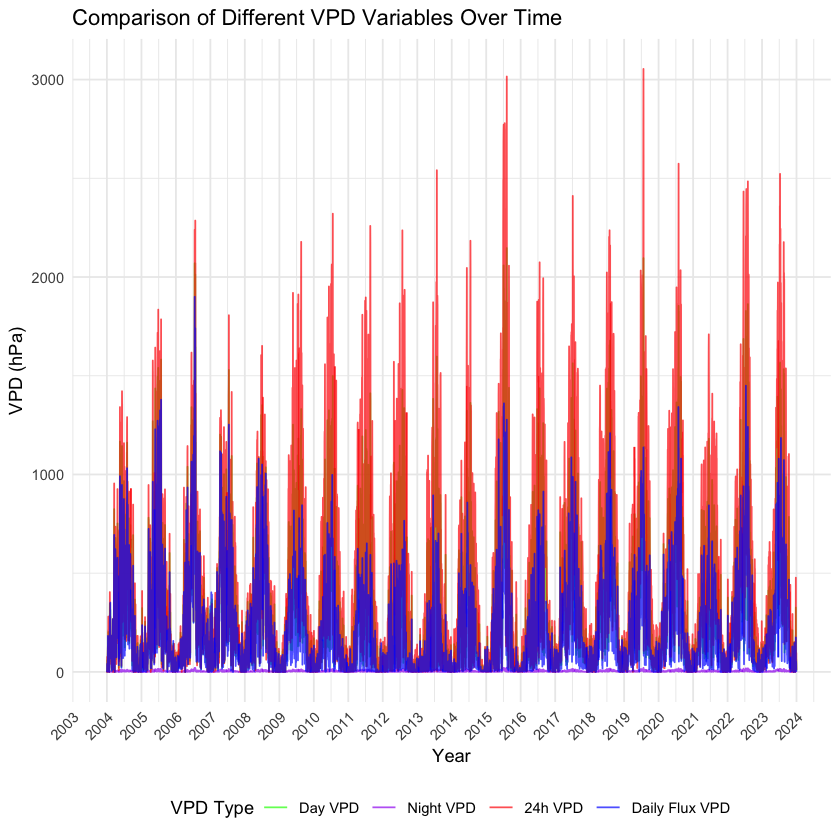

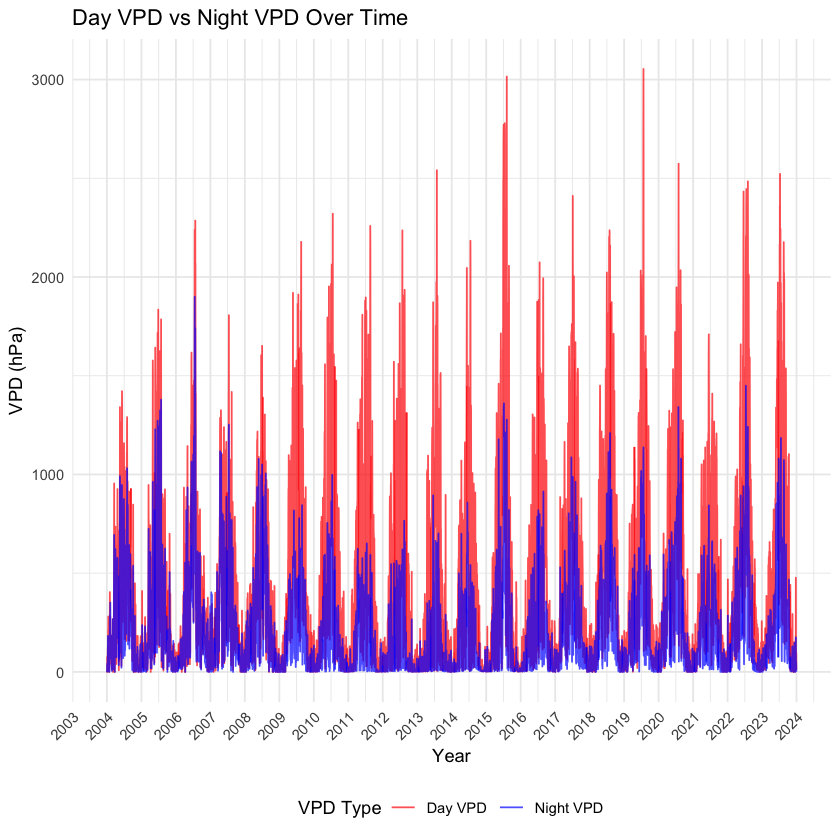

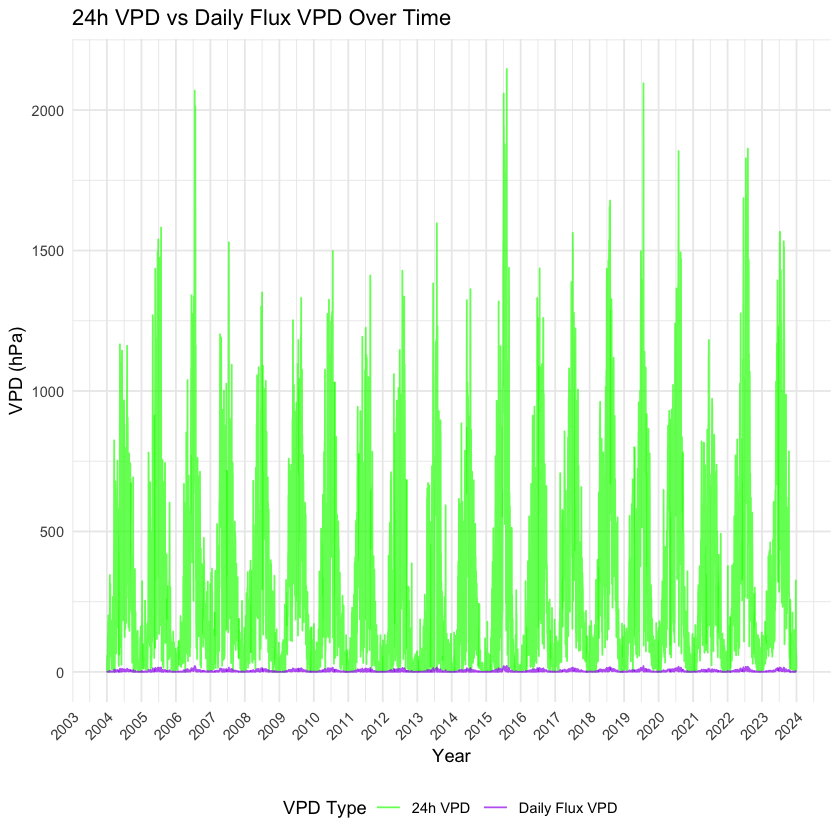

TableGrob (3 x 1) "arrange": 3 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (2-2,1-1) arrange gtable[layout]
3 3 (3-3,1-1) arrange gtable[layout]


Attache Paket: 'gridExtra'


Das folgende Objekt ist maskiert 'package:dplyr':

    combine




TableGrob (3 x 1) "arrange": 3 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (2-2,1-1) arrange gtable[layout]
3 3 (3-3,1-1) arrange gtable[layout]

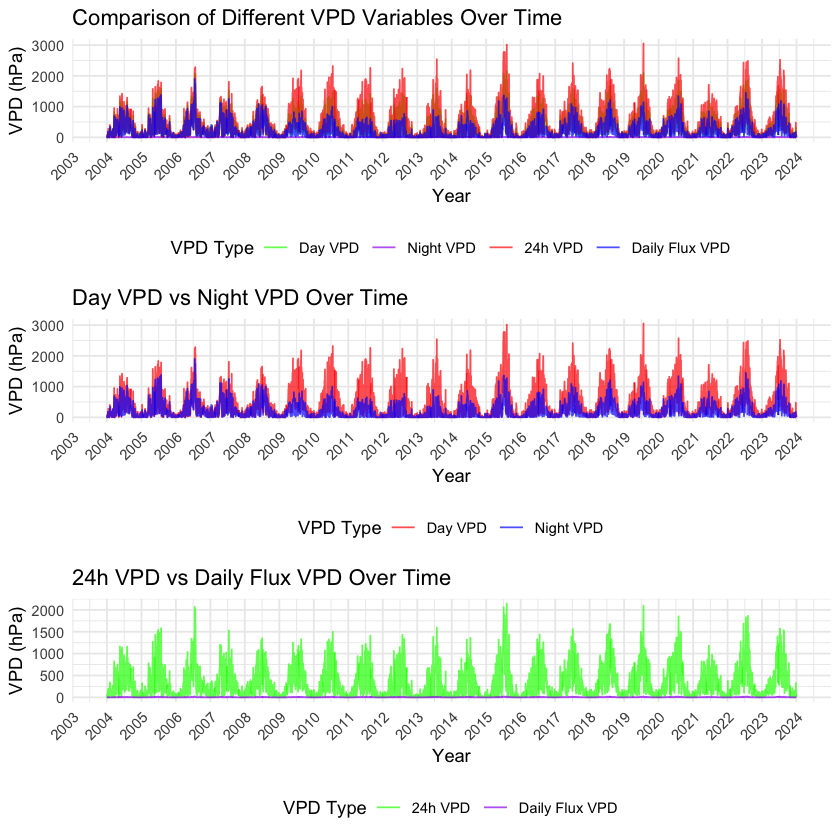

In [ ]:
# Load ggplot2 for plotting
library(ggplot2)

# Add year column for plotting
data_daily$year <- year(data_daily$date)

# Reshape data to long format for plotting multiple variables
library(tidyr)
data_long <- data_daily %>%
    select(date, year, vpd_day, vpd_night, vpd_24h, vpd_daily_flux) %>%
    pivot_longer(cols = c(vpd_day, vpd_night, vpd_24h, vpd_daily_flux), 
                 names_to = "vpd_type", 
                 values_to = "vpd_value")

# Create a single plot with different colors for each VPD type
plot <- ggplot(data_long, aes(x = date, y = vpd_value, color = vpd_type)) +
            geom_line(alpha = 0.7, size = 0.5) +
            scale_color_manual(values = c("vpd_day" = "red", 
                                        "vpd_night" = "blue", 
                                        "vpd_24h" = "green", 
                                        "vpd_daily_flux" = "purple"),
                            labels = c("Day VPD", "Night VPD", "24h VPD", "Daily Flux VPD")) +
            scale_x_date(date_labels = "%Y", date_breaks = "1 years") +
            labs(title = "Comparison of Different VPD Variables Over Time",
                x = "Year",
                y = "VPD (hPa)",
                color = "VPD Type") +
            theme_minimal() +
            theme(axis.text.x = element_text(angle = 45, hjust = 1),
                legend.position = "bottom");plot

# Create plot for Day VPD and Night VPD comparison
data_day_night <- data_daily %>%
    select(date, year, vpd_day, vpd_night) %>%
    pivot_longer(cols = c(vpd_day, vpd_night), 
                    names_to = "vpd_type", 
                    values_to = "vpd_value")

plot_day_night <- ggplot(data_day_night, aes(x = date, y = vpd_value, color = vpd_type)) +
    geom_line(alpha = 0.7, size = 0.5) +
    scale_color_manual(values = c("vpd_day" = "red", "vpd_night" = "blue"),
                        labels = c("Day VPD", "Night VPD")) +
    scale_x_date(date_labels = "%Y", date_breaks = "1 years") +
    labs(title = "Day VPD vs Night VPD Over Time",
            x = "Year",
            y = "VPD (hPa)",
            color = "VPD Type") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
            legend.position = "bottom")

# Create plot for 24h VPD and Daily Flux VPD comparison
data_24h_flux <- data_daily %>%
    select(date, year, vpd_24h, vpd_daily_flux) %>%
    pivot_longer(cols = c(vpd_24h, vpd_daily_flux), 
                    names_to = "vpd_type", 
                    values_to = "vpd_value")

plot_24h_flux <- ggplot(data_24h_flux, aes(x = date, y = vpd_value, color = vpd_type)) +
    geom_line(alpha = 0.7, size = 0.5) +
    scale_color_manual(values = c("vpd_24h" = "green", "vpd_daily_flux" = "purple"),
                        labels = c("24h VPD", "Daily Flux VPD")) +
    scale_x_date(date_labels = "%Y", date_breaks = "1 years") +
    labs(title = "24h VPD vs Daily Flux VPD Over Time",
            x = "Year",
            y = "VPD (hPa)",
            color = "VPD Type") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
            legend.position = "bottom")

# Display the plots
print(plot_day_night)
print(plot_24h_flux)

# Stack all plots together for a comprehensive view
plot_combined <- gridExtra::grid.arrange(plot, plot_day_night, plot_24h_flux, ncol = 1)
plot_combined

# Create the directory for trend plots if it does not exist
if (!dir.exists("../data/01_data_prep/trend_plots")) {
    dir.create("../data/01_data_prep/trend_plots", recursive = TRUE)
}

# Save the combined plot as a PNG file
ggsave("../data/01_data_prep/trend_plots/02a_vpd_comparison_plots.png", plot = plot_combined, width = 20, height = 15, bg = "white", dpi = 300)

# stack all single plots together
library(gridExtra)
plots_stacked <- gridExtra::arrangeGrob(plot, plot_day_night, plot_24h_flux, ncol = 1)
plots_stacked
# Save the combined plot as a PNG file
ggsave("../data/01_data_prep/trend_plots/02b_vpd_combined_plots.png", plot = plots_stacked, width = 20, height = 15, bg = "white", dpi = 300)